In [3]:
import sys
sys.path.insert(1, '/home/yannik/vssil')

import matplotlib.pyplot as plt
import pylab
import torch
import numpy as np
from torch.nn import KLDivLoss
from torch.nn.functional import interpolate
from torchvision.io import read_video
from scipy.special import kl_div

from src.utils.kpt_utils import get_image_patches, kpts_2_img_coordinates
from contrastive_loss_test_data.test_data import load_sample_images
from contrastive_loss_test_data.test_keypoints import get_perfect_keypoints, get_bad_keypoints, get_random_keypoints

In [4]:
torch.manual_seed(123)

sample_size = 4
batch_size = 16

img_tensor = load_sample_images(sample_size=sample_size,
                                path="/home/yannik/vssil/contrastive_loss_test_data/990000.mp4").unsqueeze(0)
img_tensor = interpolate(img_tensor, size=(3, 128, 128))
img_tensor = img_tensor.repeat((batch_size, 1, 1, 1, 1))
N, T, C, H, W = img_tensor.shape
print(img_tensor.shape)

torch.Size([16, 4, 3, 128, 128])


In [5]:
patch_size = (12, 12)        
n_bins = 10
hist_norm_p = float('inf')
v_min = 0
v_max = 1.0

Read key-point data and extract image patches

In [6]:
perfect_kpt_coordinates = get_perfect_keypoints(T=sample_size).unsqueeze(0)
perfect_kpt_coordinates = perfect_kpt_coordinates.repeat((batch_size, 1, 1, 1))
_, _, K, D = perfect_kpt_coordinates.shape

perfect_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=perfect_kpt_coordinates[0:1, ...],
                                        patch_size=patch_size).repeat((N, 1, 1, 1, 1, 1))

N, T, K, C, Hp, Wp  = perfect_kpt_patches.shape

In [7]:
bad_kpt_coordinates = get_bad_keypoints(T=sample_size).unsqueeze(0)
bad_kpt_coordinates = bad_kpt_coordinates.repeat((batch_size, 1, 1, 1))

bad_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=bad_kpt_coordinates[0:1, ...],
                                        patch_size=patch_size).repeat((N, 1, 1, 1, 1, 1))

In [8]:
random_kpt_coordinates = get_random_keypoints(T=sample_size).unsqueeze(0)
random_kpt_coordinates = random_kpt_coordinates.repeat((batch_size, 1, 1, 1))

random_kpt_patches = get_image_patches(image_sequence=img_tensor[0:1, ...],
                                        kpt_sequence=random_kpt_coordinates[0:1, ...],
                                        patch_size=patch_size).repeat((N, 1, 1, 1, 1, 1))

Apply Sobel filter to obtain gradients

In [9]:
from kornia.filters import sobel

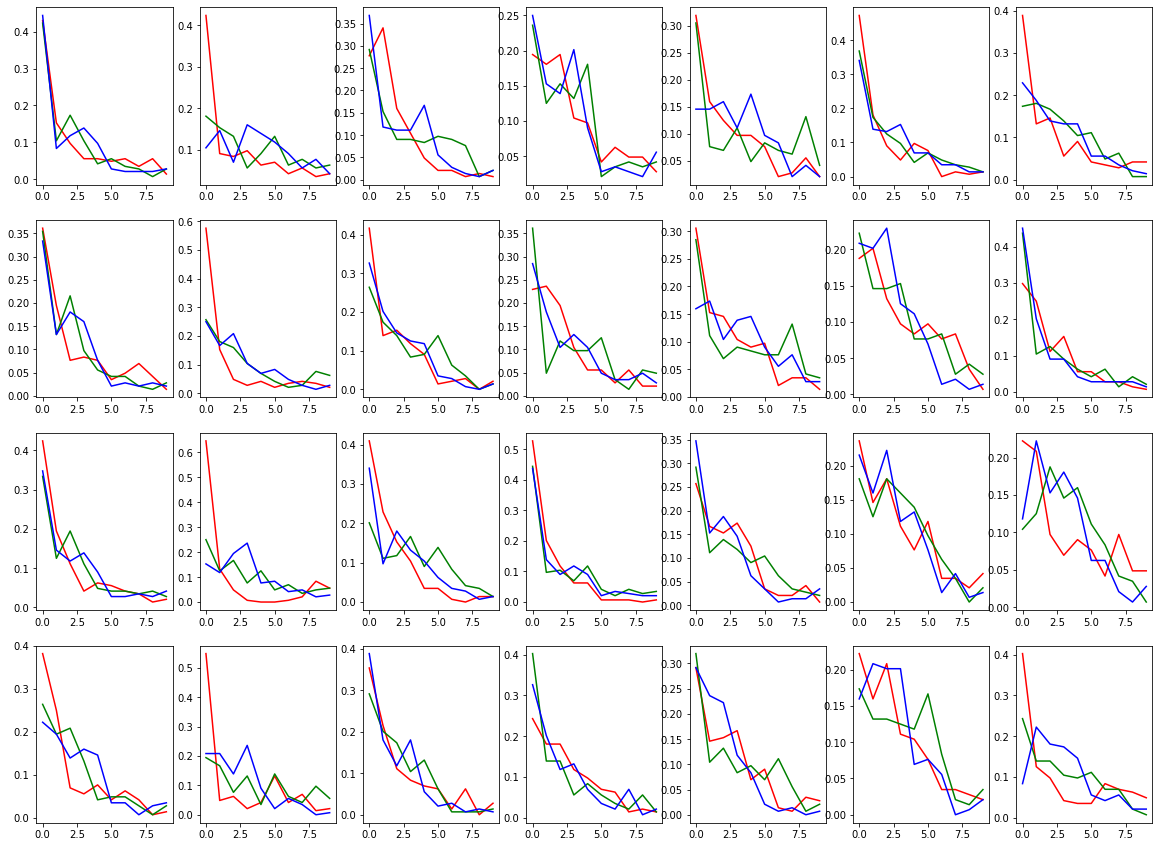

In [10]:
perfect_mag = sobel(perfect_kpt_patches.view((N*T*K, C, Hp, Wp))).view((N, T, K, C, Hp, Wp))

perfect_mag_hists = torch.empty((N, T, K, C, n_bins))

for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                perfect_mag_hists[n, t, k, c] = torch.histc(perfect_mag[n, t, k, c], bins=n_bins)
                # Normalize to prob. distribution
                perfect_mag_hists[n, t, k, c] /= torch.sum(perfect_mag_hists[n, t, k, c], dim=-1)
                
fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), perfect_mag_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), perfect_mag_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), perfect_mag_hists[0, t, k, 2], color='blue')

tensor([[0.1111, 0.1528, 0.2014, 0.1250, 0.0903, 0.2847, 0.2639],
        [0.0625, 0.1319, 0.1042, 0.2986, 0.1875, 0.0625, 0.3333],
        [0.1250, 0.1319, 0.0903, 0.2847, 0.0833, 0.0833, 0.1806]])
tensor(0.1614)


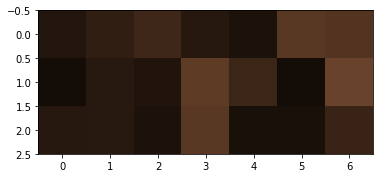

In [11]:
perfect_mag_dist = torch.empty((K, T-1))

for k in range(K):
    for t in range(T-1):
        #perfect_dist[k, t] = dkl(perfect_hists[0, t:t+1, k, :], perfect_hists[0, t+1:t+2, k, :])
        perfect_mag_dist[k, t] = torch.norm(perfect_mag_hists[0, t:t+1, k, :] - perfect_mag_hists[0, t+1:t+2, k, :], p=hist_norm_p)

print(perfect_mag_dist.T)
        
plt.imshow(perfect_mag_dist.T.cpu().numpy(), cmap='copper', vmin=v_min, vmax=v_max)

print(perfect_mag_dist.mean())

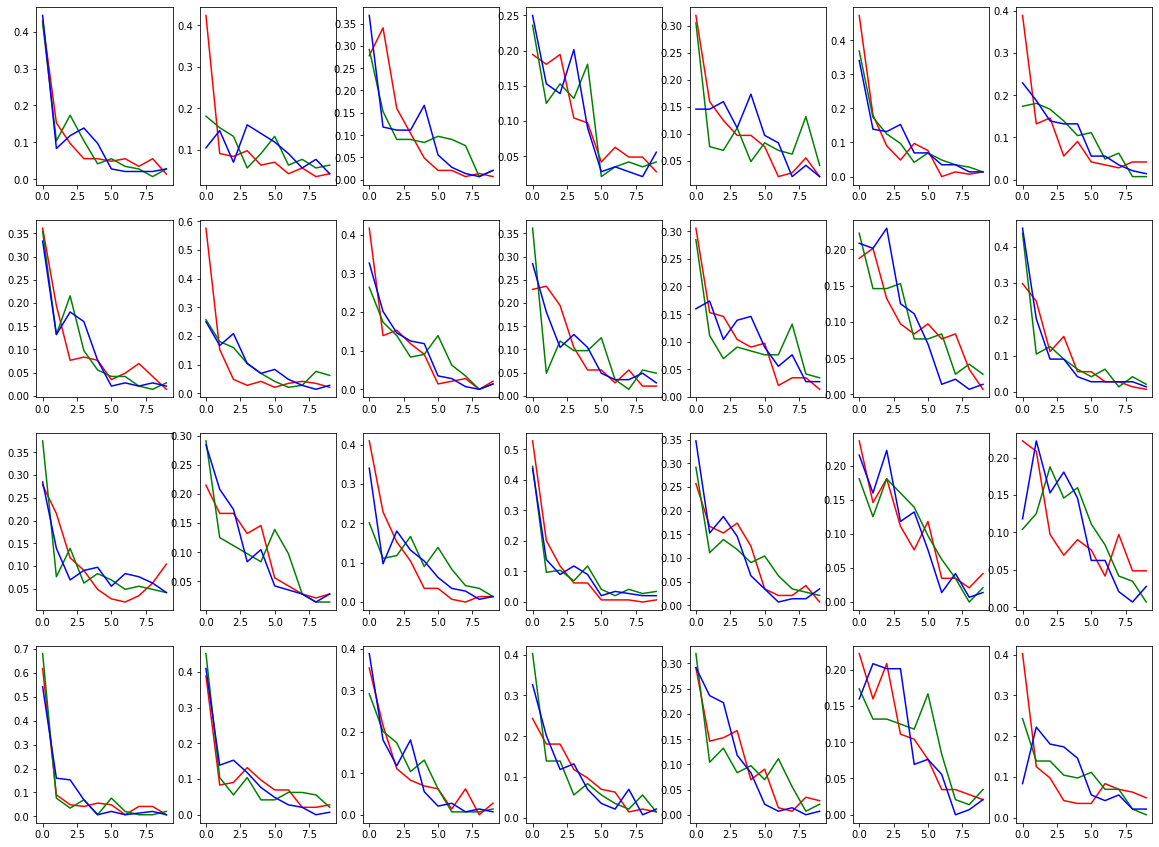

In [12]:
bad_mag = sobel(bad_kpt_patches.view((N*T*K, C, Hp, Wp))).view((N, T, K, C, Hp, Wp))

bad_mag_hists = torch.empty((N, T, K, C, n_bins))

for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                bad_mag_hists[n, t, k, c] = torch.histc(bad_mag[n, t, k, c], bins=n_bins)
                bad_mag_hists[n, t, k, c] /= torch.sum(bad_mag_hists[n, t, k, c], dim=-1)
                
fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), bad_mag_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), bad_mag_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), bad_mag_hists[0, t, k, 2], color='blue')

tensor([[0.1111, 0.1528, 0.2014, 0.1250, 0.0903, 0.2847, 0.2639],
        [0.1111, 0.3611, 0.1042, 0.2986, 0.1875, 0.0625, 0.3333],
        [0.3403, 0.1736, 0.0903, 0.2847, 0.0833, 0.0833, 0.1806]])
tensor(0.1868)


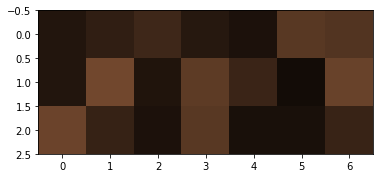

In [13]:
bad_mag_dist = torch.empty((K, T-1))

for k in range(K):
    for t in range(T-1):
        #perfect_dist[k, t] = dkl(perfect_hists[0, t:t+1, k, :], perfect_hists[0, t+1:t+2, k, :])
        bad_mag_dist[k, t] = torch.norm(bad_mag_hists[0, t:t+1, k, :] - bad_mag_hists[0, t+1:t+2, k, :], p=hist_norm_p)

print(bad_mag_dist.T)

plt.imshow(bad_mag_dist.T.cpu().numpy(), cmap='copper', vmin=v_min, vmax=v_max)

print(bad_mag_dist.mean())

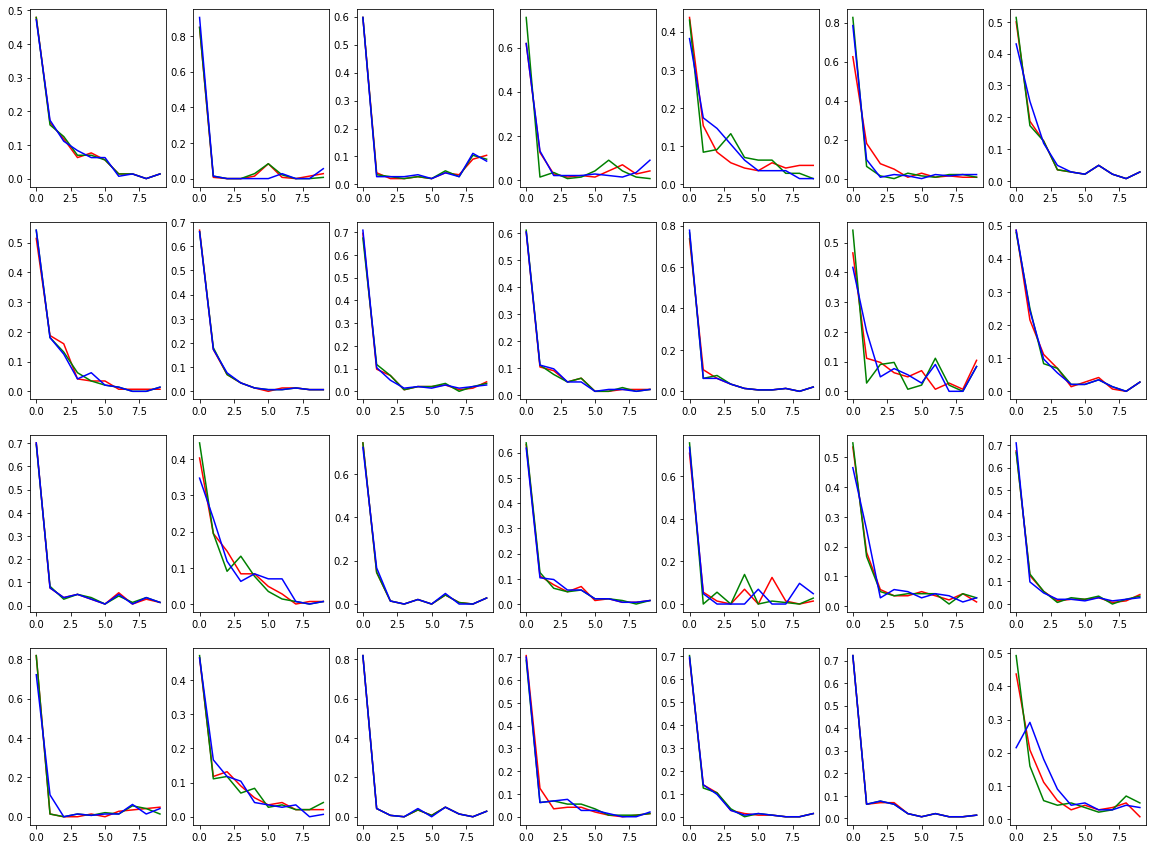

In [14]:
random_mag = sobel(random_kpt_patches.view((N*T*K, C, Hp, Wp))).view((N, T, K, C, Hp, Wp))

random_mag_hists = torch.empty((N, T, K, C, n_bins))

for n in range(N):
    for t in range(T):
        for k in range(K):
            for c in range(C):
                random_mag_hists[n, t, k, c] = torch.histc(random_mag[n, t, k, c], bins=n_bins)
                random_mag_hists[n, t, k, c] /= torch.sum(random_mag_hists[n, t, k, c], dim=-1)
                
fig, ax = plt.subplots(T, K, figsize=(20, 15))
for t in range(T):
    for k in range(K):
        ax[t][k].plot(np.arange(0, n_bins), random_mag_hists[0, t, k, 0], color='red')
        ax[t][k].plot(np.arange(0, n_bins), random_mag_hists[0, t, k, 1], color='green')
        ax[t][k].plot(np.arange(0, n_bins), random_mag_hists[0, t, k, 2], color='blue')

tensor([[0.0694, 0.2431, 0.1111, 0.1250, 0.3958, 0.3681, 0.0764],
        [0.1875, 0.3125, 0.0694, 0.0278, 0.1250, 0.1389, 0.2222],
        [0.1250, 0.1181, 0.1250, 0.0833, 0.1389, 0.2569, 0.4931]])
tensor(0.1815)


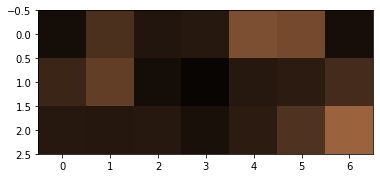

In [15]:
random_mag_dist = torch.empty((K, T-1))

for k in range(K):
    for t in range(T-1):
        #perfect_dist[k, t] = dkl(perfect_hists[0, t:t+1, k, :], perfect_hists[0, t+1:t+2, k, :])
        random_mag_dist[k, t] = torch.norm(random_mag_hists[0, t:t+1, k, :] - random_mag_hists[0, t+1:t+2, k, :], p=hist_norm_p)

print(random_mag_dist.T)
        
plt.imshow(random_mag_dist.T.cpu().numpy(), cmap='copper', vmin=v_min, vmax=v_max)

print(random_mag_dist.mean())